<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Change Inputs Here

In [46]:
task = "months"  # choose: numerals, numwords, months
prompt_types = ['done', 'lost', 'names']
num_samps_per_ptype = 128 #768 512

model_name = "gpt2-small"

save_files = True

# Setup

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pickle

In [48]:
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-c_dkad6n
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-c_dkad6n
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 829084a53836c5b8b388aa37a5ffce73b6371712
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [49]:
from transformer_lens import HookedTransformer
import torch
torch.set_grad_enabled(False)  # turn automatic differentiation off

In [50]:
!git clone https://github.com/wlg1/seqcont_circ_expms.git

Cloning into 'seqcont_circ_expms'...
remote: Enumerating objects: 470, done.
remote: Counting objects: 100% (470/470), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 470 (delta 277), reused 399 (delta 209), pack-reused 0
Receiving objects: 100% (470/470), 15.15 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (277/277), done.


In [51]:
%cd seqcont_circ_expms/src/attn_pats

/content/seqcont_circ_expms/src/attn_pats/seqcont_circ_expms/src/attn_pats/seqcont_circ_expms/src/attn_pats


In [52]:
from viz_attn_pat import *

# Load Model and Dataset

## Model

Decide which model to use (eg. gpt2-small vs -medium)

In [53]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


## Dataset

In [54]:
prompts_list = []

for i in prompt_types:
    file_name = f'/content/seqcont_circ_expms/data/{task}/{task}_prompts_{i}.pkl'
    with open(file_name, 'rb') as file:
        filelist = pickle.load(file)

    print(filelist[0]['text'])
    # change this to less if have CUDA have out of memory issues
    prompts_list += filelist [:num_samps_per_ptype] #768 512 256 128

prompts = [prompt['text'] for prompt in prompts_list]

Van done in January. Hat done in February. Ring done in March. Desk done in April. Sun done in
Oil lost in January. Apple lost in February. Tree lost in March. Snow lost in April. Apple lost in
Marcus born in January. Victoria born in February. George born in March. Brandon born in April. Jamie born in


We need to use 128 because we are saving local_cache, which is a lot of memory even on an A100.

In [55]:
tokens = model.to_tokens(prompts, prepend_bos=True)
# tokens = tokens.cuda() # Move the tokens to the GPU

# get the cache to get attention patterns from
original_logits, local_cache = model.run_with_cache(tokens) # Run the model and cache all activations

# Functions

## Index attn pat fns

In [56]:
# Tokenized sentence is stored in token_list and the tokens you are interested in are token1 and token2
token1 = " March"
token2 = " February"

local_tokens = tokens[0]
token_list = model.to_str_tokens(local_tokens)

In [57]:
def get_attn_val(token_list, token1, token2, layer, head_index):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = token_list.index(token1)
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        # print(f"The index of '{token1}' is {query_ind}")
        # print(f"The index of '{token2}' is {key_ind}")

        patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
        heatmap_value = patterns[query_ind, key_ind]
        print(f'The avg heatmap value at "{token1}" "{token2}" is {heatmap_value} for {layer}.{head_index}')

get_attn_val(token_list, token1, token2, 4, 4)

The avg heatmap value at " March" " February" is 0.27643096446990967 for 4.4


In [58]:
def get_attn_val_fromEnd(token_list, token2, layer, head_index):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = -1
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        # print(f"The index of '{token1}' is {query_ind}")
        # print(f"The index of '{token2}' is {key_ind}")

        patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
        heatmap_value = patterns[query_ind, key_ind]
        print(f'The avg heatmap value at last token to "{token2}" is {heatmap_value} for {layer}.{head_index}')

get_attn_val_fromEnd(token_list, token1, 9, 1)
get_attn_val_fromEnd(token_list, token2, 9, 1)

The avg heatmap value at last token to " March" is 0.15055996179580688 for 9.1
The avg heatmap value at last token to " February" is 0.022596299648284912 for 9.1


In [59]:
get_ind(token_list, token1, token2, printInd=True)

The index of ' March' is 14
The index of ' February' is 9


(14, 9)

# Early heads

## Number Detection/Similar Type Heads

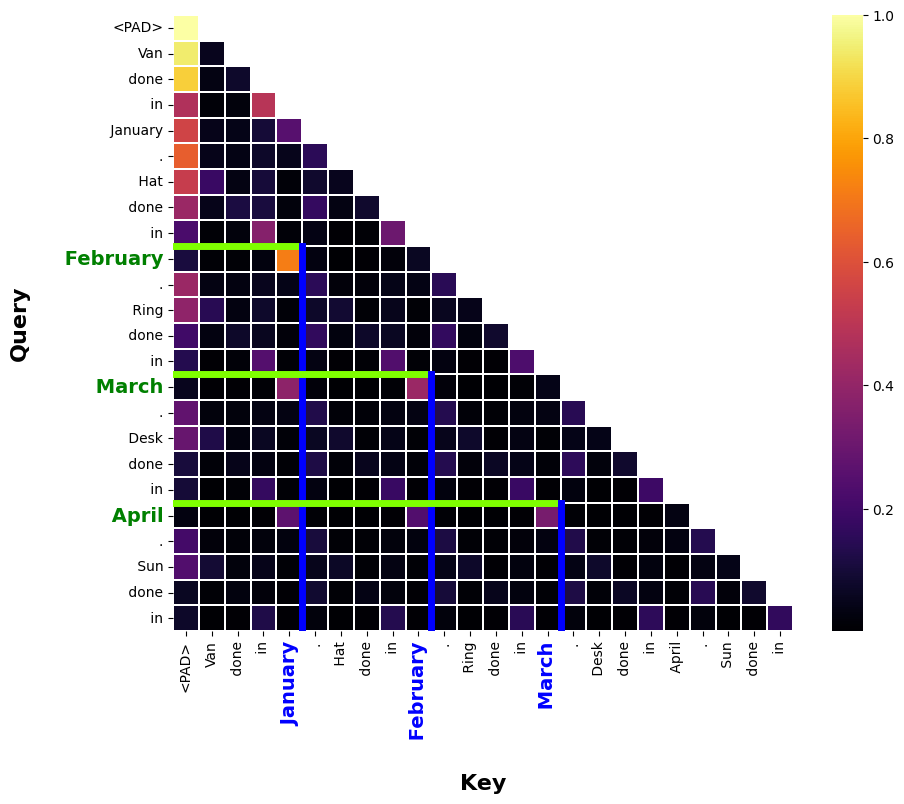

In [60]:
layer = 1
head_ind = 5
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    task,
    highlightLines = 'early',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

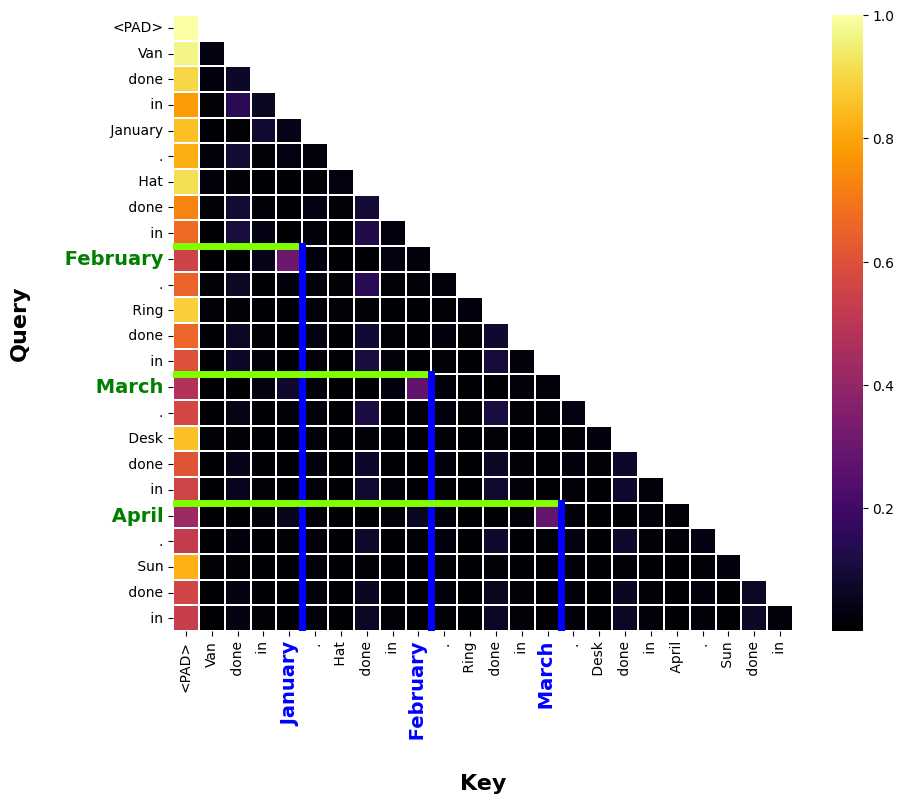

In [61]:
layer = 4
head_ind = 4
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    task,
    highlightLines = 'early',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

Lighter/Warmer "sunnier" colors mean higher attention values.


## Duplicate Heads

In [62]:
def viz_attnPat_dupl(
    layer, head_index,
    highlightLines = True
):
    patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
    patterns_np = patterns.cpu().numpy()

    str_tokens = model.to_str_tokens(tokens[0])
    str_tokens[0] = '<END>' # Rename the first token string as '<END>'

    # Create a mask for the cells above the diagonal
    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        # cmap='viridis',
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,  # Set linewidth to create grid lines between cells
        linecolor='white',  # Set line color to white
        # cbar_kws={'label': 'Attention Weight'}
        mask=mask
    )

    ax.set_xlabel('Key', fontsize=16, fontweight='bold')
    ax.set_ylabel('Query', fontsize=16, fontweight='bold')

    if highlightLines:
        for i in range(0, 19):
            rect = patches.Rectangle((i, i), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = patches.Rectangle((i, i+5), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = patches.Rectangle((i, i+10), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

    plt.show()

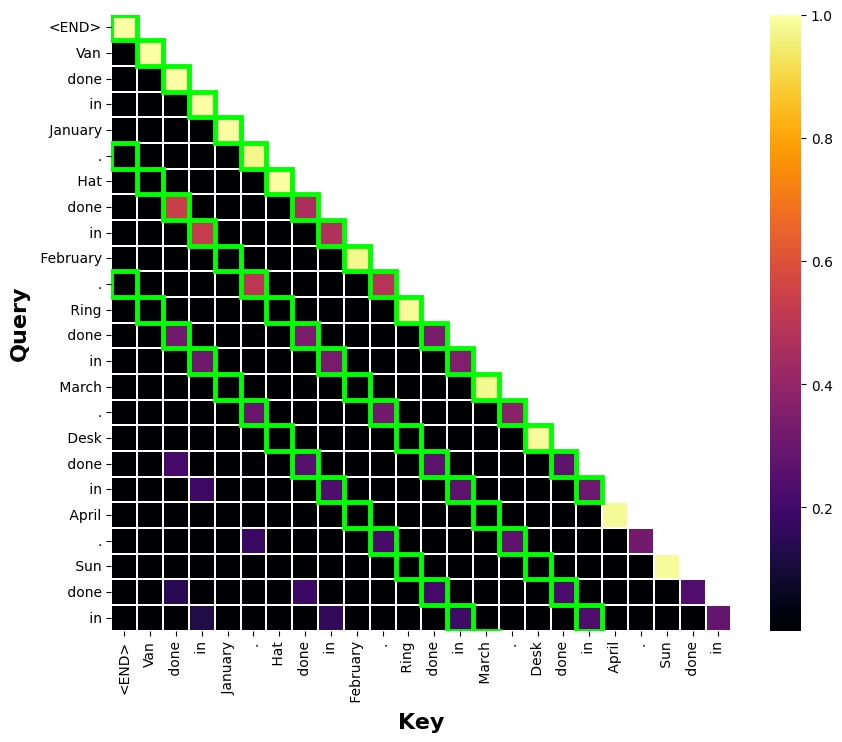

In [63]:
viz_attnPat_dupl(layer = 0, head_index = 1)

# Middle heads

Notice the last token in the sequence (last row) pays attention to the most recent seq members.

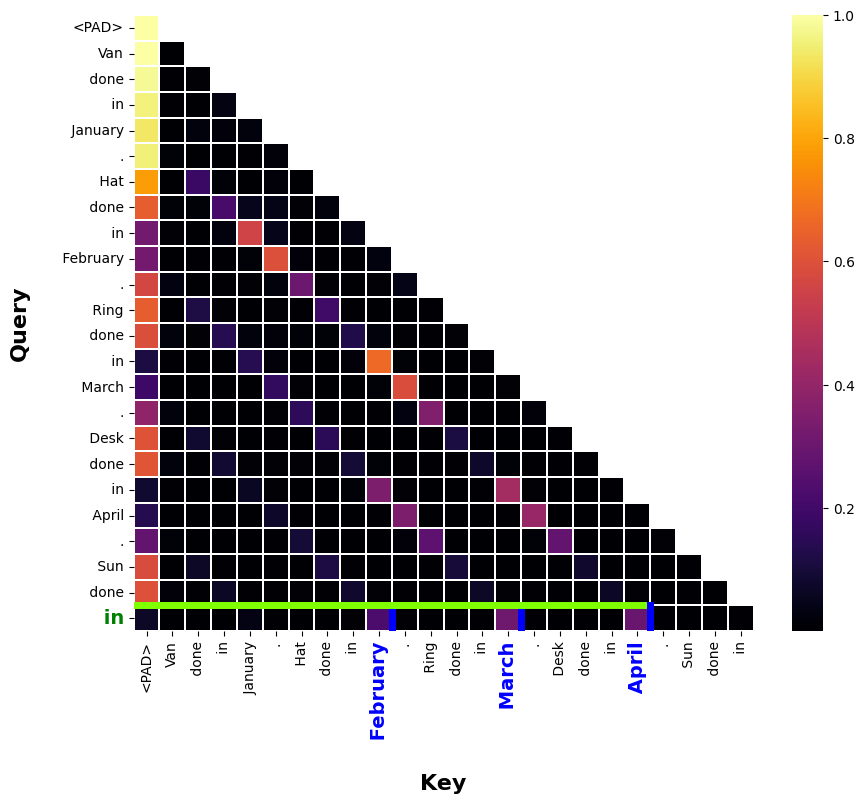

In [64]:
layer = 7
head_ind = 11
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    task,
    highlightLines = 'mid',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

This pays attention to all numbers except the first seq member; albeit, not that strong for each. More recent seq members are stronger.

# Late heads

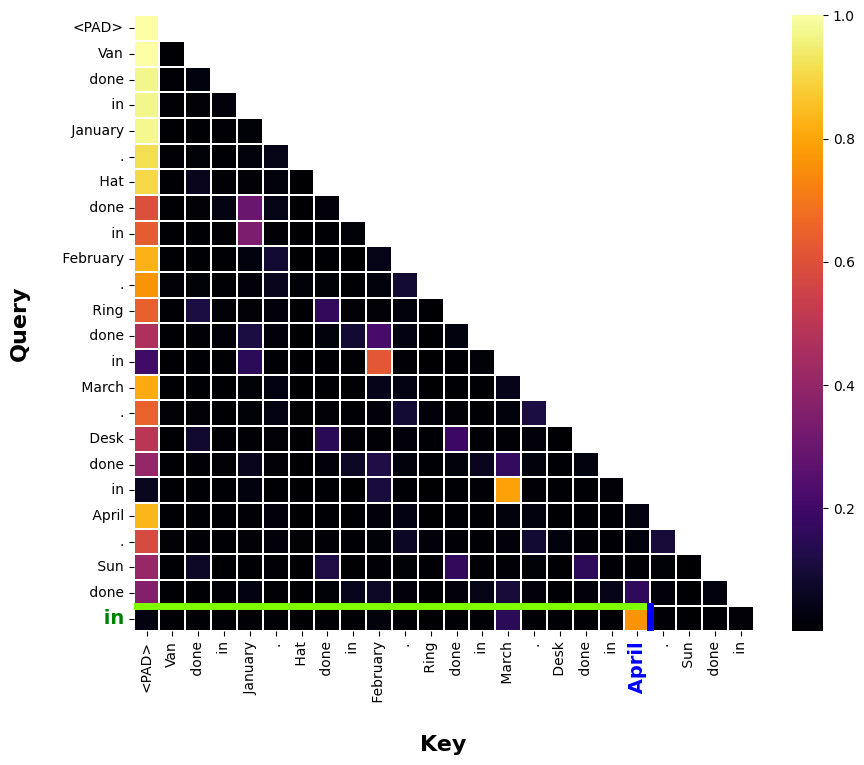

In [65]:
layer = 9
head_ind = 1
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    task,
    highlightLines = 'late',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

The last row (token) pays attention a lot to ONLY the most recent number token.

# Download files from nb

In [66]:
from google.colab import files
if save_files:
    for layer, head_ind in [(1,5), (4,4), (7,11), (9,1)]:
        savePlotName = f'attnpat{layer}_{head_ind}_{task}'
        files.download(savePlotName + '.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>